## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.sgdr import *
from torch.utils import data
from torchvision import transforms
from transforms import utils
from tensorboardX import SummaryWriter
import os, sys, random
import scipy.misc as m
import timeit
import cv2
torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data')
GT_PATH = Path('data/gt')
IM_PATH = Path('data/img')
LIST_PATH  = Path('data/list/train_aug.txt')
VAL_LIST_PATH = Path('data/list/val.txt')
SAMPLE_DIR = PATH/'samples'

## Training Data

### Fastai data (transforms don't work)

In [ ]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return np.array(Image.open(os.path.join(self.path, self.y[i]))).astype(np.float32)
    def get_c(self): return 0
    
def get_pascal_labels_tuple():
        return [(0,0,0), (128,0,0), (0,128,0), (128,128,0),
                          (0,0,128), (128,0,128), (0,128,128), (128,128,128),
                          (64,0,0), (192,0,0), (64,128,0), (192,128,0),
                          (64,0,128), (192,0,128), (64,128,128), (192,128,128),
                          (0, 64,0), (128, 64, 0), (0,192,0), (128,192,0),
                          (0,64,128)]

def im2index(im):
    color2index = {lbl: i for i, lbl in enumerate(get_pascal_labels_tuple())}
    assert len(im.shape) == 3
    height, width, ch = im.shape
    assert ch == 3
    m_lable = np.zeros((height, width, 1), dtype=np.uint8)
    for w in range(width):
        for h in range(height):
            r, g, b = im[h, w, :]
            r, g, b = int(r), int(g), int(b)
            m_lable[h, w, :] = color2index[(r, g, b)]
    return m_lable[:,:,0]

In [ ]:
trn_list = read_files(LIST_PATH)
val_list = read_files(VAL_LIST_PATH)
trn_x, val_x= [Path('img')/f'{o}.jpg' for o in trn_list], [Path('img')/f'{o}.jpg' for o in val_list]
trn_y, val_y  = [Path('gt')/f'{v}.png' for v in trn_list], [Path('gt')/f'{v}.png' for v in val_list]
len(trn_x), len(val_x), len(trn_y), len(val_y)

In [ ]:
pascal_stats = [np.array(list(mean)), np.array(list(std))]
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS), RandomZoom(1.5, 0.75, tfm_y=TfmType.CLASS), 
            RandomRotate(15, tfm_y=TfmType.CLASS), Scale(512, tfm_y=TfmType.CLASS, sz_y=512)]
tfms = tfms_from_stats(pascal_stats, sz=512, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms=tfms, path=PATH)
md = ImageData(PATH, datasets, 4, num_workers=6, classes=None)

In [ ]:
trn = iter(md.trn_dl)
x, y = next(trn)

In [ ]:
print(y.shape)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax = show_img(md.trn_ds.denorm(x)[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.7)

In [ ]:
decoded_samp = decode_segmap(samp)*255
decoded_samp[decoded_samp==255] = 0
print(decoded_samp.shape)
show_img(im2index(decoded_samp))
show_img(decoded_samp)

In [ ]:
masks = to_np(y.permute(0, 2, 3, 1))
encs = np.array([im2index(mask*255) for mask in masks])
show_img(masks[0])
show_img(encs[0])

In [ ]:
samp = np.array(Image.open(os.path.join('data', trn_y[1])))
print(samp.shape)
show_img(samp)
show_img(decode_segmap(samp))
print(decode_segmap(samp).shape)
print(encode_segmap(decode_segmap(samp)).shape)
enc_samp = encode_segmap(decode_segmap(samp))
#print(enc_samp())
show_img(enc_samp)
show_img(decode_segmap(enc_samp))

### Custom Transforms

In [4]:
class FixedResize(object):
    def __init__(self, size, flagvals=None):
        self.size = (size, size)
        self.flagvals = flagvals
        
    def __call__(self, sample):
        elems = list(sample.keys())
        for elem in elems:
            if self.flagvals is None:
                sample[elem] = utils.fixed_resize(sample[elem], self.size)
            else:
                sample[elem] = utils.fixed_resize(sample[elem], self.size, flagval=self.flagvals[elem])
                
        return sample

class Normalize(object):
    def __init__(self, mean=(0.,0.,0.), std=(1.,1.,1.)):
        self.mean,self.std = mean,std
    
    def __call__(self, sample):
        sample['image'] /= 255.
        sample['image'] -= self.mean
        sample['image'] /= self.std
        return sample
        
class ScaleRotate(object):
    def __init__(self, rots=(-30,30), scales=(0.75,1.5)):
        assert(isinstance(rots, type(scales)))
        self.rots,self.scales = rots,scales
    
    def __call__(self, sample):
        rot = (self.rots[1]-self.rots[0]) * random.random() - (self.rots[1]-self.rots[0])/2
        sc = (self.scales[1]-self.scales[0]) * random.random() - (self.scales[1]-self.scales[0])/2 + 1
        
        for elem in sample.keys():
            tmp = sample[elem]
            (h, w) = tmp.shape[:2]
            center = (w/2, h/2)
            assert(center != 0)
            M = cv2.getRotationMatrix2D(center, rot, sc)
            if tmp.ndim == 2 or elem == 'gt':
                flagval = cv2.INTER_NEAREST
            else:
                flagval = cv2.INTER_CUBIC
            tmp = cv2.warpAffine(tmp, M, (w, h), flags=flagval)
            sample[elem] = tmp
        
        return sample
    
class RandomHorizontalFlip(object):
    def __call__(self, sample):
        if random.random() > 0.5:
            for elem in sample.keys():
                tmp = sample[elem]
                tmp = cv2.flip(tmp, 1)
                sample[elem] = tmp
        return sample
    
class ToTensor(object):
    def __call__(self, sample):
        for elem in sample.keys():
            tmp = sample[elem].astype(np.float32)
            if tmp.ndim == 2:
                tmp = tmp[:,:,np.newaxis]
            tmp = tmp.transpose(2, 0, 1)
            if elem == 'image':
                sample[elem] = torch.from_numpy(tmp).float()
            else:
                sample[elem] = torch.from_numpy(tmp).long()
        return sample

In [5]:
def read_files(path_to_file):
    with open(path_to_file) as f:
        img_list=[]
        for line in f:
            img_list.append(line[:-1])
    return img_list
    
def get_pascal_labels():
        return np.asarray([[0,0,0], [128,0,0], [0,128,0], [128,128,0],
                          [0,0,128], [128,0,128], [0,128,128], [128,128,128],
                          [64,0,0], [192,0,0], [64,128,0], [192,128,0],
                          [64,0,128], [192,0,128], [64,128,128], [192,128,128],
                          [0, 64,0], [128, 64, 0], [0,192,0], [128,192,0],
                          [0,64,128]])

def decode_segmap(segmap):
    colr_lbls = get_pascal_labels()
    r = segmap.copy()
    g = segmap.copy()
    b = segmap.copy()
    for i in range(len(colr_lbls)):
        r[r==i] = colr_lbls[i, 0]
        g[g==i] = colr_lbls[i, 1]
        b[b==i] = colr_lbls[i, 2]
    rgb = np.zeros((segmap.shape[0], segmap.shape[1], 3))
    rgb[:, :, 0] = r/255.0
    rgb[:, :, 1] = g/255.0
    rgb[:, :, 2] = b/255.0
    return rgb

def encode_segmap(mask):
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    for ii, label in enumerate(get_pascal_labels()):
        print(label)
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        print(label_mask[label_mask>0])
    label_mask = label_mask.astype(int)
    return label_mask

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

def denorm(img,gt=None):
    img = to_np(img.permute(1, 2, 0))
    img = img * std + mean
    if gt is not None:
        gt = to_np(gt.permute(1, 2, 0))
        gt = gt[:,:,0]
    return img, gt

In [6]:
class Pascal_Dataset(data.Dataset):
    def __init__(self, list_path, transform=None):
        self.data_list=read_files(list_path)
        self.transform=transform
        
    def __len__(self): 
        return len(self.data_list)
    
    def __getitem__(self, i):
        data = self.data_list[i]
        _img = np.array(Image.open(str(IM_PATH/f'{data}.jpg')).convert('RGB')).astype(np.float32)
        _target = np.array(Image.open(str(GT_PATH/f'{data}.png'))).astype(np.float32)
        samp = {'image': _img, 'gt': _target}
        if self.transform is not None:
            samp = self.transform(samp)
        return samp['image'], samp['gt']
    
class Pascal_Sampleset(data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir,self.transform=img_dir,transform
        self.img_paths=list(self.img_dir.iterdir())
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, i):
        _img = np.array(Image.open(str(self.img_paths[i])).convert('RGB')).astype(np.float32)
        samp = {'image': _img}
        if self.transform is not None:
            samp = self.transform(samp)
        return samp['image']

In [7]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [7]:
trn_tfms = transforms.Compose([RandomHorizontalFlip(), 
                               ScaleRotate(rots=(-15, 15), scales=(0.75, 1.5)), FixedResize(512), 
                               Normalize(mean=mean, std=std), ToTensor()])
val_tfms = transforms.Compose([FixedResize(512), Normalize(mean=mean, std=std), ToTensor()])
trn_ds = Pascal_Dataset(LIST_PATH,transform=trn_tfms)
val_ds = Pascal_Dataset(VAL_LIST_PATH,transform=val_tfms)
trn_dl = data.DataLoader(trn_ds, batch_size=6, shuffle=True)
val_dl = data.DataLoader(val_ds, batch_size=6, shuffle=False)
md = ModelData('data', trn_dl, val_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


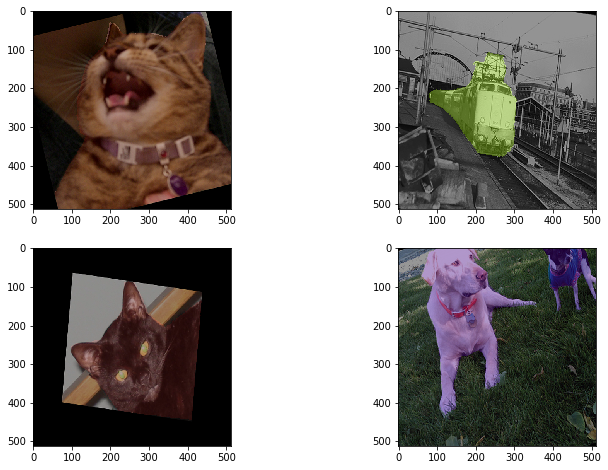

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
imgs, gts = next(iter(md.trn_dl))
for i, ax in enumerate(axes.flat):
    img, gt = denorm(imgs[i], gts[i])
    ax=show_img(img, ax=ax)
    show_img(decode_segmap(gt), ax=ax, alpha=0.4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


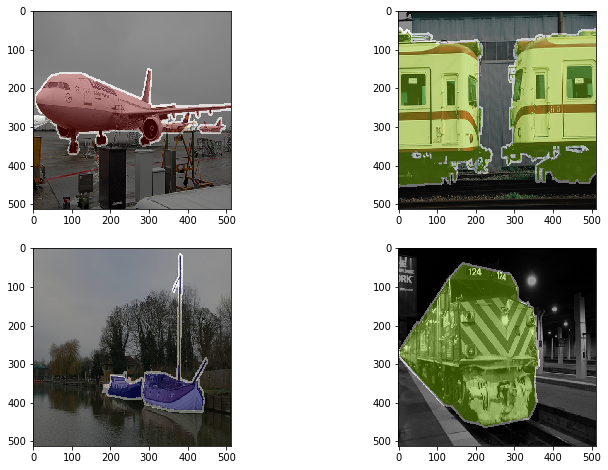

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
imgs, gts = next(iter(md.val_dl))
for i, ax in enumerate(axes.flat):
    img, gt = denorm(imgs[i], gts[i])
    ax=show_img(img, ax=ax)
    show_img(decode_segmap(gt), ax=ax, alpha=0.4)

## Model

In [8]:
class SeperableConv2D(nn.Module):
    def __init__(self, in_dims, out_dims, kernel_size=3, stride=1, padding=0, dilation=1, bias=False):
        super(SeperableConv2D, self).__init__()
        self.conv1 = nn.Conv2d(in_dims, in_dims, kernel_size, 
                                stride, padding, dilation, groups=in_dims, bias=bias)
        self.pointwise = nn.Conv2d(in_dims, out_dims, kernel_size=1, 
                                   stride=1, padding=0, dilation=1, groups=1, bias=bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x
    
def fixed_padding(inputs, kernel_size, rate):
    kernel_size_effective = kernel_size + (kernel_size-1) * (rate-1)
    pad_total = kernel_size_effective-1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end), mode='reflect')
    return padded_inputs
        
        

class SeperableConv2D_same(nn.Module):
    def __init__(self, in_dims, out_dims, kernel_size=3, stride=1, dilation=1, bias=False):
        super(SeperableConv2D_same, self).__init__()
        self.conv1 = nn.Conv2d(in_dims, in_dims, kernel_size, stride, 0, dilation, groups=in_dims, bias=bias)
        self.pointwise = nn.Conv2d(in_dims, out_dims, 1, 1, 0, 1, 1, bias=bias)
        
    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.pointwise(x)
        return x
    
class Block(nn.Module):
    def __init__(self, in_dims, out_dims, reps, stride=1, dilation=1, start_with_relu=True, grow_first=True):
        super(Block, self).__init__()
        if out_dims != in_dims or stride != 1:
            self.skip = nn.Conv2d(in_dims, out_dims, 1, stride=stride, bias=False)
            self.skipbn = nn.BatchNorm2d(out_dims)
        else:
            self.skip = None
            
        self.relu = nn.ReLU(inplace=True)
        rep = []
        filters = in_dims
        if grow_first:
            rep.append(self.relu)
            rep.append(SeperableConv2D_same(in_dims, out_dims, 3, stride=1, dilation=dilation, bias=False))
            rep.append(nn.BatchNorm2d(out_dims))
            filters = out_dims
        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeperableConv2D_same(filters, filters, 3, stride=1, dilation=dilation, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeperableConv2D_same(in_dims, out_dims, 3, stride=1, dilation=dilation, bias=False))
            rep.append(nn.BatchNorm2d(out_dims))
        if not start_with_relu:
            rep = rep[1:]
        if stride != 1:
            rep.append(SeperableConv2D_same(out_dims, out_dims, 3, stride=2))
        self.rep = nn.Sequential(*rep)
        
    def forward(self, x):
        out = self.rep(x)
        if self.skip is not None:
            skip = self.skip(x)
            skip = self.skipbn(skip)
        else:
            skip = x
        out += skip
        return out

In [9]:
class Xception(nn.Module):
    def __init__(self, in_dims=3, pretrained=False):
        super(Xception, self).__init__()
        # entry flow
        self.conv1 = nn.Conv2d(in_dims, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.block1 = Block(64, 128, reps=2, stride=2, start_with_relu=False)
        self.block2 = Block(128, 256, reps=2, stride=2, start_with_relu=True, grow_first=True)
        self.block3 = Block(256, 728, reps=2, stride=2, start_with_relu=True, grow_first=True)
        # middle blocks
        self.block4 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block5 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block6 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block7 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block8 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block9 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block10 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block11 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block12 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block13 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block14 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block15 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block16 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block17 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block18 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block19 = Block(728, 728, reps=3, stride=1, start_with_relu=True, grow_first=True)
        self.block20 = Block(728, 1024, reps=2, dilation=2, start_with_relu=True, grow_first=False)
        self.conv3 = SeperableConv2D_same(1024, 1536, 3, stride=1, dilation=2)
        self.bn3 = nn.BatchNorm2d(1536)
        self.conv4 = SeperableConv2D_same(1536, 1536, 3, stride=1, dilation=2)
        self.bn4 = nn.BatchNorm2d(1536)
        self.conv5 = SeperableConv2D_same(1536, 2048, 3, stride=1, dilation=2)
        self.bn5 = nn.BatchNorm2d(2048)
        self._init_weights()
        if pretrained:
            self._load_xception_weights()
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.block1(x)
        low_level_feat = x
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)
        x = self.block17(x)
        x = self.block18(x)
        x = self.block19(x)
        x = self.block20(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        return x, low_level_feat
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
    def _load_xception_weights(self):
        pretrain_dict = model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                if 'pointwise' in k:
                    v = v.unsqueeze(-1).unsqueeze(-1)
                if k.startswith('block12'):
                    model_dict[k.replace('block12', 'block20')] = v
                elif k.startswith('block11'):
                    model_dict[k.replace('block11', 'block12')] = v
                    model_dict[k.replace('block11', 'block13')] = v
                    model_dict[k.replace('block11', 'block14')] = v
                    model_dict[k.replace('block11', 'block15')] = v
                    model_dict[k.replace('block11', 'block16')] = v
                    model_dict[k.replace('block11', 'block17')] = v
                    model_dict[k.replace('block11', 'block18')] = v
                    model_dict[k.replace('block11', 'block19')] = v
                elif k.startswith('conv3'):
                    model_dict[k] = v
                elif k.startswith('bn3'):
                    model_dict[k] = v
                    model_dict[k.replace('bn3', 'bn4')] = v
                elif k.startswith('conv4'):
                    model_dict[k.replace('conv4', 'conv5')] = v
                elif k.startswith('bn4'):
                    model_dict[k.replace('bn4', 'bn5')] = v
                else:
                    model_dict[k] = v
                
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

In [10]:
class ASPP_Module(nn.Module):
    def __init__(self, in_dims, out_dims, rate, padding='fixed'):
        super(ASPP_Module, self).__init__()
        #self.atrous_conv = nn.Conv2d(in_dims, out_dims, 3, stride=1, padding=rate, dilation=rate)
        self.conv1 = nn.Conv2d(in_dims, in_dims, 3, stride=1, padding=1 if padding=='same' else 0, 
                                   dilation=rate, groups=in_dims, bias=False)
        self.bn1 = nn.BatchNorm2d(in_dims)
        self.relu = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(out_dims)
        self.pointwise = nn.Conv2d(in_dims, out_dims, 1, 1, 0, 1, 1, bias=False)
        self.padding = padding
        self._init_weights()
        
    def forward(self, x):
        if self.padding == 'fixed':
            x = fixed_padding(x, self.conv1.kernel_size[0], self.conv1.dilation[0])
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.pointwise(x)))
        return x
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class DeepLabv3_plus(nn.Module):
    def __init__(self, in_channels=3, num_classes=21, pretrained=False):
        print(f'Constructing Deeplabv3+ with {in_channels} input channels and {num_classes} classes')
        super(DeepLabv3_plus, self).__init__()
        self.xception_features = Xception(in_dims=in_channels, pretrained=pretrained)
        
        rates = [1, 6, 12, 18]
        self.aspp1 = ASPP_Module(2048, 256, rate=rates[0])
        self.aspp2 = ASPP_Module(2048, 256, rate=rates[1])
        self.aspp3 = ASPP_Module(2048, 256, rate=rates[2])
        self.aspp4 = ASPP_Module(2048, 256, rate=rates[3])
        self.relu = nn.ReLU(inplace=True)
        
        #self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Conv2d(2048, 256, 1, stride=1))
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), 
                                             nn.Conv2d(2048, 256, 1, stride=1), 
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True))
        
        self.conv1 = nn.Conv2d(1280, 256, 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.drop = nn.Dropout(p=0.1)
        self.conv2 = nn.Conv2d(128, 48, 1)
        self.bn2 = nn.BatchNorm2d(48)
        
        self.last_conv = nn.Sequential(ASPP_Module(304, 256, 1, padding='same'), 
                                       ASPP_Module(256, 256, 1, padding='same'), 
                                       nn.Conv2d(256, num_classes, 1, stride=1))
        
        #self.last_conv = nn.Sequential(nn.Conv2d(304, 256, 3, stride=1, padding=1),
        #                               nn.BatchNorm2d(256),
        #                               nn.ReLU(inplace=True),
        #                               nn.Conv2d(256, 256, 3, stride=1, padding=1),
        #                               nn.BatchNorm2d(256),
        #                               nn.ReLU(inplace=True),
        #                               nn.Conv2d(256, num_classes, 1, stride=1))
        
    def forward(self, x):
        x, low_level_feat = self.xception_features(x)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        
        x = self.drop(self.relu(self.bn1(self.conv1(x))))
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        
        low_level_feat = self.relu(self.bn2(self.conv2(low_level_feat)))
        
        x = torch.cat([x, low_level_feat], dim=1)
        x = self.last_conv(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        return x
    
    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

In [11]:
def get_1x_lr_params(model):
    b = [model.xception_features, model.global_avg_pool, model.bn1, model.bn2]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k
                
def get_10x_lr_params(model):
    b = [model.aspp1, model.aspp2, model.aspp3, model.aspp4, model.conv1, model.conv2, model.last_conv]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

In [12]:
class DeepLabv3plusModel():
    def __init__(self, model, name='DeepLabv3+'):
        self.model, self.name = model, name
    
    def get_layer_groups(self, precompute):
        return [children(self.model)]

In [13]:
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n**2).reshape(n, n)

def get_iou(pred,gt):
    
    pred = torch.max(F.log_softmax(pred, dim=1), dim=1)
    gt = gt[:,0,:,:]
    pred, gt = to_np(pred[1]), to_np(gt)
        
    if pred.shape!= gt.shape:
        print('pred shape',pred.shape, 'gt shape', gt.shape)
    assert(pred.shape == gt.shape)    
    gt = gt.astype(np.float32)
    pred = pred.astype(np.float32)

    count = np.zeros((max_label+1,))
    for j in range(max_label+1):
        x = np.where(pred==j)
        p_idx_j = set(zip(x[0].tolist(),x[1].tolist()))
        x = np.where(gt==j)
        GT_idx_j = set(zip(x[0].tolist(),x[1].tolist()))
        #pdb.set_trace()     
        n_jj = set.intersection(p_idx_j,GT_idx_j)
        u_jj = set.union(p_idx_j,GT_idx_j)
    
        
        if len(GT_idx_j)!=0:
            count[j] = float(len(n_jj))/float(len(u_jj))

    result_class = count
    Aiou = np.sum(result_class[:])/float(len(np.unique(gt))) 
    
    return Aiou

## Training

In [16]:
bs=5
epochs=300
test_interval=1
snapshot=1
num_ave_grad = 1
lr=5e-7
wd=5e-4
momentum=0.9
lr_epoch=1
save_dir='weights'

net = DeepLabv3_plus(in_channels=3, num_classes=21, pretrained=True)
criterion = utils.cross_entropy2d

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=wd)

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
trn_tfms = transforms.Compose([RandomHorizontalFlip(), 
                               ScaleRotate(rots=(-15, 15), scales=(0.5, 1.5)), FixedResize(512), 
                               Normalize(mean=mean, std=std), ToTensor()])
val_tfms = transforms.Compose([FixedResize(512), Normalize(mean=mean, std=std), ToTensor()])
trn_ds = Pascal_Dataset(LIST_PATH,transform=trn_tfms)
val_ds = Pascal_Dataset(VAL_LIST_PATH,transform=val_tfms)
trn_dl = data.DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = data.DataLoader(val_ds, batch_size=bs, shuffle=False)
md = ModelData('data', trn_dl, val_dl)

trn_len = len(md.trn_dl.dataset)
val_len = len(md.val_dl.dataset)

ave_grad=0
trn_run_loss=0
val_run_loss=0

resume_epoch = 1
lr_ = utils.lr_poly(lr, resume_epoch, epochs, power=0.9)
optimizer = optim.SGD(net.parameters(), lr=lr_, momentum=momentum, weight_decay=wd)
net.load_state_dict(torch.load(f'{save_dir}\\deeplabv3+_{resume_epoch}.pth'))
net.cuda()

Constructing Deeplabv3+ with 3 input channels and 21 classes


C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packag

C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packag

C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packag

DeepLabv3_plus(
  (xception_features): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (rep): Sequential(
        (0): SeperableConv2D_same(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [17]:
for epoch in range(resume_epoch+1, epochs):
    start_time = timeit.default_timer()
    
    if epoch % (lr_epoch) == (lr_epoch-1):
        lr_ = utils.lr_poly(lr, epoch, epochs, power=0.9)
        print(f'(policy lr) learning rate: {lr_}')
        optimizer = optim.SGD(net.parameters(), lr=lr_, momentum=momentum, weight_decay=wd)
    
    iou_list=[]
    net.train()
    pbar = tqdm_notebook(total=len(md.trn_dl.dataset)//bs)
    for (i, (imgs, gts)) in enumerate(md.trn_dl):
        imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
        outputs = net.forward(imgs)
        loss = criterion(outputs, gts, size_average=False, batch_average=True)
        
        iou = get_iou(outputs, gts)
        iou_list.append(iou)
        
        trn_run_loss += loss.item()
        pbar.update(1)
        
        if i % (trn_len//bs) == (trn_len//bs)-1:
            trn_run_loss /= (trn_len//bs)
            print(f'epoch num: {epoch} \nTraining images: {i * bs + imgs.data.shape[0]}')
            print(f'train running loss: {trn_run_loss}')
            trn_run_loss = 0
            stop_time = timeit.default_timer()
            print(f'exec time: {stop_time-start_time}')
            
        loss /= num_ave_grad
        loss.backward()
        ave_grad += 1
        
        if ave_grad % num_ave_grad == 0:
            optimizer.step()
            optimizer.zero_grad()
            ave_grad = 0
    
    print(f'Training Epoch {epoch} Mean IOU = {np.sum(iou_list)/len(iou_list)}')
    pbar.close()
    
    if (epoch % snapshot) == (snapshot - 1):
        torch.save(net.state_dict(), f'{save_dir}\\deeplabv3+_{epoch}.pth')
        print(f'saved model at {save_dir}\\deeplabv3+_{epoch}.pth')
        
    if (epoch % test_interval) == (test_interval - 1):
        net.eval()
        val_iou_list = []
        for i, (imgs, gts) in enumerate(md.val_dl):
            imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
            with torch.no_grad():
                outputs = net.forward(imgs)
            loss = criterion(outputs, gts, size_average=False, batch_average=True)
            output = torch.max(F.log_softmax(outputs, dim=1), dim=1)
            gts = gts[:,0,:,:]
            output, gts = to_np(output[1]), to_np(gts)
            val_iou = get_iou(output, gts)
            val_iou_list.append(val_iou)
            val_run_loss += loss.item()
            
        val_run_loss /= (val_len//bs)
        print(f'Validation epoch: {epoch} \nValidation images: {i * bs + imgs.data.shape[0]}')
        print(f'Validation Loss: {val_run_loss}')
        print(f'Validation Mean IOU: {np.sum(val_iou_list)/len(val_iou_list)}')
        val_run_loss = 0

(policy lr) learning rate: 4.969989975469645e-07


epoch num: 2 
Training images: 10580
train running loss: 305695.55566221644
exec time: 2510.951040502373
Training Epoch 2 Mean IOU = 0.19634702801239812

saved model at weights\deeplabv3+_2.pth
Validation epoch: 2 
Validation images: 1449
Validation Loss: 299335.7843047145
Validation Mean IOU: 0.20768453327461597
(policy lr) learning rate: 4.95497741706417e-07


epoch num: 3 
Training images: 10580
train running loss: 299238.1733001536
exec time: 2477.9953365655488
Training Epoch 3 Mean IOU = 0.20916184333345783

saved model at weights\deeplabv3+_3.pth
Validation epoch: 3 
Validation images: 1449
Validation Loss: 284580.9909710208
Validation Mean IOU: 0.19766870790828434
(policy lr) learning rate: 4.939959803064135e-07


epoch num: 4 
Training images: 10580
train running loss: 285987.1405253131
exec time: 2494.977380081942
Training Epoch 4 Mean IOU = 0.2270705266780422

saved model at weights\deeplabv3+_4.pth
Validation epoch: 4 
Validation images: 1449
Validation Loss: 308731.7138300173
Validation Mean IOU: 0.22940021382664252
(policy lr) learning rate: 4.924937114678609e-07


epoch num: 5 
Training images: 10580
train running loss: 276724.45186968334
exec time: 2476.1095677352196
Training Epoch 5 Mean IOU = 0.240069994838483

saved model at weights\deeplabv3+_5.pth
Validation epoch: 5 
Validation images: 1449
Validation Loss: 262775.61626838235
Validation Mean IOU: 0.24855577656975142
(policy lr) learning rate: 4.909909332982876e-07


epoch num: 6 
Training images: 10580
train running loss: 268797.64192092983
exec time: 2474.61818258068
Training Epoch 6 Mean IOU = 0.2514639671652977

saved model at weights\deeplabv3+_6.pth
Validation epoch: 6 
Validation images: 1449
Validation Loss: 271274.3982482699
Validation Mean IOU: 0.2810346364560295
(policy lr) learning rate: 4.894876438917019e-07


epoch num: 7 
Training images: 10580
train running loss: 260072.69996455577
exec time: 2475.0220138320346
Training Epoch 7 Mean IOU = 0.2626082665967321

saved model at weights\deeplabv3+_7.pth
Validation epoch: 7 
Validation images: 1449
Validation Loss: 266889.8201232699
Validation Mean IOU: 0.29386026002099097
(policy lr) learning rate: 4.879838413284487e-07


epoch num: 8 
Training images: 10580
train running loss: 251591.99469444115
exec time: 2464.5040436732033
Training Epoch 8 Mean IOU = 0.2762825158994536

saved model at weights\deeplabv3+_8.pth
Validation epoch: 8 
Validation images: 1449
Validation Loss: 232441.28330449827
Validation Mean IOU: 0.3041731786315407
(policy lr) learning rate: 4.864795236750652e-07


epoch num: 9 
Training images: 10580
train running loss: 239660.39942883092
exec time: 2456.8875491624385
Training Epoch 9 Mean IOU = 0.29142758093363275

saved model at weights\deeplabv3+_9.pth
Validation epoch: 9 
Validation images: 1449
Validation Loss: 231814.63365051904
Validation Mean IOU: 0.2995480488212191
(policy lr) learning rate: 4.849746889841331e-07


epoch num: 10 
Training images: 10580
train running loss: 233397.1905422968
exec time: 2457.1683945466866
Training Epoch 10 Mean IOU = 0.3068596200223178

saved model at weights\deeplabv3+_10.pth
Validation epoch: 10 
Validation images: 1449
Validation Loss: 259893.58718101212
Validation Mean IOU: 0.281062446250624
(policy lr) learning rate: 4.834693352941294e-07


epoch num: 11 
Training images: 10580
train running loss: 226215.39541550982
exec time: 2457.147516670102
Training Epoch 11 Mean IOU = 0.3220840236939689

saved model at weights\deeplabv3+_11.pth
Validation epoch: 11 
Validation images: 1449
Validation Loss: 214026.12810878028
Validation Mean IOU: 0.3408794998921503
(policy lr) learning rate: 4.819634606292754e-07


epoch num: 12 
Training images: 10580
train running loss: 216860.49006084594
exec time: 2463.0961634608902
Training Epoch 12 Mean IOU = 0.3387489498589523

saved model at weights\deeplabv3+_12.pth
Validation epoch: 12 
Validation images: 1449
Validation Loss: 202062.0980752595
Validation Mean IOU: 0.3673628435327878
(policy lr) learning rate: 4.804570629993833e-07


epoch num: 13 
Training images: 10580
train running loss: 210512.75365149457
exec time: 2455.7531388290736
Training Epoch 13 Mean IOU = 0.3484555121795621

saved model at weights\deeplabv3+_13.pth
Validation epoch: 13 
Validation images: 1449
Validation Loss: 200388.0066906358
Validation Mean IOU: 0.3703247572986329
(policy lr) learning rate: 4.789501403997001e-07


epoch num: 14 
Training images: 10580
train running loss: 206124.81365009156
exec time: 2454.6463192673
Training Epoch 14 Mean IOU = 0.35836703427192074

saved model at weights\deeplabv3+_14.pth
Validation epoch: 14 
Validation images: 1449
Validation Loss: 216327.80411980968
Validation Mean IOU: 0.35428442588706627
(policy lr) learning rate: 4.774426908107498e-07


epoch num: 15 
Training images: 10580
train running loss: 197337.53660724836
exec time: 2461.3741946659284
Training Epoch 15 Mean IOU = 0.37548517926140673

saved model at weights\deeplabv3+_15.pth
Validation epoch: 15 
Validation images: 1449
Validation Loss: 186621.303633218
Validation Mean IOU: 0.3759297360195186
(policy lr) learning rate: 4.759347121981738e-07


epoch num: 16 
Training images: 10580
train running loss: 193717.58207370923
exec time: 2459.766326852492
Training Epoch 16 Mean IOU = 0.3866884889173548

saved model at weights\deeplabv3+_16.pth
Validation epoch: 16 
Validation images: 1449
Validation Loss: 180985.629960532
Validation Mean IOU: 0.41776217209411703
(policy lr) learning rate: 4.744262025125674e-07


epoch num: 17 
Training images: 10580
train running loss: 188059.37411758624
exec time: 2464.4026555465825
Training Epoch 17 Mean IOU = 0.39555280806442095

saved model at weights\deeplabv3+_17.pth
Validation epoch: 17 
Validation images: 1449
Validation Loss: 183214.04467182094
Validation Mean IOU: 0.42123117091509
(policy lr) learning rate: 4.72917159689316e-07


epoch num: 18 
Training images: 10580
train running loss: 181775.2286245422
exec time: 2483.9210633126495
Training Epoch 18 Mean IOU = 0.4056535628853722

saved model at weights\deeplabv3+_18.pth
Validation epoch: 18 
Validation images: 1449
Validation Loss: 183337.7609618296
Validation Mean IOU: 0.4011321800923198
(policy lr) learning rate: 4.7140758164842714e-07


epoch num: 19 
Training images: 10580
train running loss: 180367.86917016187
exec time: 2489.049894883101
Training Epoch 19 Mean IOU = 0.4125784111167924

saved model at weights\deeplabv3+_19.pth
Validation epoch: 19 
Validation images: 1449
Validation Loss: 200548.13771896626
Validation Mean IOU: 0.39371453980201404
(policy lr) learning rate: 4.698974662943611e-07


epoch num: 20 
Training images: 10580
train running loss: 174821.90819574078
exec time: 2510.6089038485734
Training Epoch 20 Mean IOU = 0.42677148469570814

saved model at weights\deeplabv3+_20.pth
Validation epoch: 20 
Validation images: 1449
Validation Loss: 182966.93275573096
Validation Mean IOU: 0.45328189587151446
(policy lr) learning rate: 4.6838681151585873e-07


KeyboardInterrupt: 

## Test

In [18]:
net.load_state_dict(torch.load(f'{save_dir}\\deeplabv3+_20.pth'))
net.cuda()

DeepLabv3_plus(
  (xception_features): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (rep): Sequential(
        (0): SeperableConv2D_same(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

- Epoch 50 Validation Acc: 62.4
- Epoch 51 Validation Acc: 63.1
- Epoch 52 Validation Acc: 63.6
- Epoch 53 Validation Acc: 60.2
- Epoch 54 Validation Acc: 64.0
- Epoch 55 Validation Acc: 64.0
- Epoch 56 Validation Acc: 66.4
- Epoch 57 Validation Acc: 64.1
- Epoch 58 Validation Acc: 64.0
- Epoch 59 Validation Acc: 66.4
- Epoch 60 Validation Acc: 64.1
- Epoch 61 Validation Acc: 64.1
- Epoch 62 Validation Acc: 63.9

In [19]:
test_dl = iter(md.val_dl)
iou_list = []
net.eval()

pbar = tqdm_notebook(total=(val_len//5))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = net.forward(imgs)
    output = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    gts = gts[:,0,:,:]
    output, gts = to_np(output[1]), to_np(gts)
    iou = get_iou(output, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))

Mean IOU =  0.45328189587151446


In [20]:
test_dl = iter(md.val_dl)

In [96]:
imgs, gts = next(test_dl)
imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
with torch.no_grad():
    outputs = net.forward(imgs)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img, gt = denorm(imgs[i], gts[i])
    out = torch.max(F.log_softmax(outputs[i], dim=0), dim=0)
    out = to_np(out[1])
    ax=show_img(img, ax=ax)
    show_img(decode_segmap(out), ax=ax, alpha=0.6)

NameError: name 'net' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


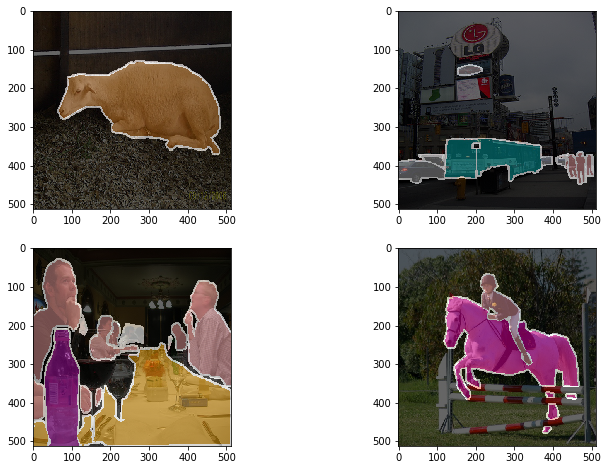

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img, gt = denorm(imgs[i], gts[i])
    ax=show_img(img, ax=ax)
    show_img(decode_segmap(gt), ax=ax, alpha=0.6)

## Fast.ai Training

In [14]:
class TensorboardLogger(Callback):
    def __init__(self, model, md, log_name, metrics_names=[], path=None, histogram_freq=100):
        super().__init__()
        self.model = model
        self.md = md
        self.metrics_names = ["validation_loss"]
        self.metrics_names += metrics_names
        self.histogram_freq = histogram_freq
        
        path = path or os.path.join(md.path, "logs")
        self.log_dir = os.path.join(path, log_name)
        
    def on_train_begin(self):
        self.iteration = 0
        self.epoch = 0
        self.writer = SummaryWriter(log_dir=self.log_dir)
    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_epoch_end(self, metrics):
        self.epoch += 1
        
        for val, name in zip(metrics, self.metrics_names):
            self.writer.add_scalar(name, val, self.iteration) 
                
    def on_phase_end(self): pass
    def on_batch_end(self, loss):
        self.iteration += 1
        self.writer.add_scalar("loss", loss, self.iteration)
        
        if self.iteration%self.histogram_freq==0:
            for name, param in self.model.named_parameters():
                self.writer.add_histogram(name, param, self.iteration)
    def on_train_end(self):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                dummy_input = tuple(next(iter(self.md.trn_dl))[:-1])
                self.writer.add_graph(self.model, dummy_input)
        except Exception as e:
            print("Unable to create graph.")
            print(e)
        self.writer.close()

In [15]:
max_label=21
bs=4
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
trn_tfms = transforms.Compose([RandomHorizontalFlip(), 
                               ScaleRotate(rots=(-30, 30), scales=(0.75, 1.75)), FixedResize(512), 
                               Normalize(mean=mean, std=std), ToTensor()])
val_tfms = transforms.Compose([FixedResize(512), Normalize(mean=mean, std=std), ToTensor()])
trn_ds = Pascal_Dataset(LIST_PATH,transform=trn_tfms)
val_ds = Pascal_Dataset(VAL_LIST_PATH,transform=val_tfms)
trn_dl = data.DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = data.DataLoader(val_ds, batch_size=bs, shuffle=False)
test_ds = Pascal_Sampleset(SAMPLE_DIR, transform=val_tfms)
test_dl = data.DataLoader(test_ds, batch_size=bs, shuffle=False)
md = ModelData('data', trn_dl, val_dl, test_dl=test_dl)

In [16]:
m = to_gpu(DeepLabv3_plus(pretrained=True))
model = DeepLabv3plusModel(m)
learner = ConvLearner(md, model)

Constructing Deeplabv3+ with 3 input channels and 21 classes


C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packag

C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packag

C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\Aidan\Anaconda3\lib\site-packag

In [17]:
learner.crit = utils.cross_entropy2d
learner.metrics = [accuracy, get_iou]
learner.opt_fn = optim.Adam
learner.unfreeze()

In [17]:
# 1e-5 wd bad (val loss increases around 30+ epochs, val iou low)
# 4e-5 wd val loss too high (i think)

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.633739   1.607187   0.71492    0.167564  



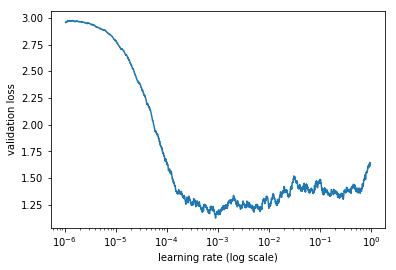

In [19]:
wd=2e-3
learner.lr_find(start_lr=1e-6, end_lr=1, wds=wd, use_wd_sched=True)
learner.sched.plot()

In [18]:
lr=8e-4
wd=4e-4
learner.fit(lr, 1, cycle_len=36, wds=wd, use_wd_sched=True, use_clr=(50, 36))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.108034   1.17753    0.695839   0.207816  
    1      1.054083   1.123319   0.657254   0.238088                                                                   
    2      0.991348   0.969827   0.640352   0.308354                                                                   
    3      0.869911   0.900551   0.643012   0.331185                                                                   
    4      0.872055   0.894677   0.663422   0.350954                                                                   
    5      0.787921   0.823504   0.634464   0.354305                                                                   
    6      0.807565   1.201972   0.577717   0.39618                                                                    
    7      0.665192   0.757308   0.6352     0.415224                                                     

[0.4210381406064359, 0.629708971296038, 0.6469201700172702]

In [19]:
#learner.save('DeepLabv3+_11')

### ASPP Conv+BN

In [18]:
lr=6e-4
wd=4e-5
learner.fit(lr, 1, cycle_len=100, wds=wd, use_wd_sched=True, use_clr=(100, 100))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.145939   1.120058   0.698333   0.221251  
    1      1.065842   1.032286   0.672063   0.254731                                                                   
    2      0.957921   0.964352   0.645865   0.313423                                                                   
    3      0.904796   1.052114   0.601626   0.316981                                                                   
    4      0.761193   0.853688   0.634336   0.376346                                                                   
    5      0.8868     0.772164   0.651266   0.395535                                                                   
    6      0.707219   0.687305   0.656765   0.413685                                                                   
    7      0.743435   0.664576   0.640728   0.459959                                                     

[0.339156936311656, 0.6486445105100517, 0.7198143681696051]

In [19]:
#learner.save('DeepLabv3+_13')

### ASPP Conv+BN+ReLU (last conv = Conv+BN)

In [17]:
lr=6e-4
wd=4e-5
learner.fit(lr, 1, cycle_len=100, wds=wd, use_wd_sched=True, use_clr=(100, 100))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.139154   1.163583   0.687353   0.233538  
    1      1.056331   1.053259   0.657898   0.28702                                                                    
    2      0.908152   0.985896   0.616417   0.346607                                                                   
    3      0.872055   1.109719   0.586512   0.334167                                                                   
    4      0.784203   0.803532   0.63486    0.369059                                                                   
    5      0.708493   0.777031   0.632367   0.403704                                                                   
    6      0.684116   0.787068   0.613566   0.420028                                                                   
    7      0.712555   0.831932   0.583608   0.451905                                                     

[0.3581748532068326, 0.6413029920158096, 0.7339597594263766]

In [18]:
#learner.save('DeepLabv3+_14')

### ASPP Conv+ReLU+BN (conv+bn after asppp, last conv = Conv+ReLU)

In [18]:
lr=6e-5
wd=4e-5
learner.fit(lr, 1, cycle_len=100, wds=wd, use_wd_sched=True, use_clr=(100, 100))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.131722   1.180535   0.711456   0.193425  
    1      1.074419   1.05937    0.686343   0.252485                                                                   
    2      1.048638   1.08144    0.639327   0.302203                                                                   
    3      0.884961   0.891745   0.651012   0.356828                                                                   
    4      0.789061   0.767922   0.660913   0.366746                                                                   
    5      0.723244   0.761933   0.648706   0.412643                                                                   
    6      0.7312     0.839274   0.615328   0.438958                                                                   
    7      0.608527   0.605734   0.647174   0.473628                                                     

[0.33582693510132877, 0.652677896024442, 0.7587989033988776]

In [19]:
#learner.save('DeepLabv3+_15')

### ASPP Conv+ReLU+BN (conv+bn+relu+drop after global ave, conv+bn+relu after asppp, last conv = Conv+BN+ReLU)

In [18]:
lr=8e-5
wd=5e-4
learner.fit(lr, 1, cycle_len=50, wds=wd, use_wd_sched=True, use_clr=(100, 50))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.235829   1.190549   0.713756   0.190325  
    1      1.048667   1.032532   0.684244   0.260334                                                                   
    2      0.930637   0.92456    0.65627    0.305958                                                                   
    3      0.862483   0.791512   0.640799   0.38033                                                                    
    4      0.764933   0.694838   0.648142   0.419357                                                                   
    5      0.694701   0.624756   0.629162   0.489607                                                                   
    6      0.588223   0.596441   0.618686   0.521001                                                                   
    7      0.513845   0.52124    0.621552   0.560982                                                     

[0.2615970606852022, 0.6462657282153355, 0.7460150522337547]

In [19]:
#learner.save('DeepLabv3+_16')

### ASPP Conv+ReLU+BN (conv+bn+relu+drop after global ave, conv+bn+relu after asppp, last conv = Conv+BN+ReLU)

In [18]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [19]:
lr=8e-5
wd=1e-3
tensor_log = TensorboardLogger(learner.model, md, 'Pascal Training', metrics_names=['accuracy', 'get_iou'])
learner.fit(lr, 1, cycle_len=100, wds=wd, use_wd_sched=True, use_clr=(100, 100), 
            callbacks=[tensor_log], best_save_name='DeepLabv3+_Best')

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.248082   1.23957    0.714532   0.181439  
    1      1.056421   1.075367   0.693696   0.273643                                                                   
    2      0.955771   0.943547   0.678837   0.305109                                                                   
    3      0.890744   0.81614    0.668661   0.349343                                                                   
    4      0.751542   0.745579   0.631381   0.406821                                                                   
    5      0.671871   0.712534   0.625355   0.438267                                                                   
    6      0.61198    0.629566   0.629497   0.494459                                                                   
    7      0.605196   0.56946    0.630358   0.534918                                                     

KeyboardInterrupt: 

In [ ]:
learner.save('DeepLabv3+_20')

In [19]:
lr=8e-5
wd=2e-3
learner.fit(lr, 1, cycle_len=50, wds=wd, use_wd_sched=True, use_clr=(200, 50))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.264412   1.214551   0.706047   0.196667  
    1      1.17045    1.082721   0.700069   0.230209                                                                   
    2      0.979543   0.954284   0.672668   0.286653                                                                   
    3      0.867135   0.854257   0.64864    0.33571                                                                    
    4      0.793996   0.777441   0.647331   0.390411                                                                   
    5      0.712023   0.689828   0.628527   0.442078                                                                   
    6      0.696417   0.658331   0.620448   0.479014                                                                   
    7      0.634022   0.563843   0.626421   0.518751                                                     

[0.27857473640194264, 0.6441078021495074, 0.7424575736522049]

In [20]:
learner.save('DeepLabv3+_18')

### Fastai Cyclical Training with Lower Epochs

In [16]:
lr = 7e-4
learner.fit(lr, 1, cycle_len=10, use_clr=(32, 10))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      1.14438    1.151706   0.695384   0.228891  
    1      1.044078   1.335941   0.580486   0.262691                                                                   
    2      0.9279     1.015994   0.630615   0.301594                                                                   
    3      0.909544   1.013136   0.608926   0.327829                                                                   
    4      0.821568   0.807741   0.635916   0.368373                                                                   
    5      0.736794   0.743552   0.644114   0.388282                                                                   
    6      0.646153   0.680847   0.64206    0.416815                                                                   
    7      0.655888   0.633409   0.652749   0.431666                                                     

[0.552143236824033, 0.6484358058953137, 0.48878215886529547]

In [17]:
#learner.save('DeepLabv3+_1')

In [17]:
learner.load('DeepLabv3+_1')

In [18]:
lr=7e-4
learner.fit(lr/5, 1, cycle_len=20, use_clr=(32, 20))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      0.530756   0.59664    0.634018   0.479083  
    1      0.545673   0.56891    0.645558   0.497969                                                                   
    2      0.5768     0.536048   0.649801   0.514715                                                                   
    3      0.507241   0.560037   0.628839   0.521037                                                                   
    4      0.492843   0.517197   0.638075   0.537653                                                                   
    5      0.465386   0.518862   0.625465   0.553945                                                                   
    6      0.491961   0.526205   0.63942    0.537991                                                                   
    7      0.403544   0.507417   0.626734   0.565535                                                     

[0.4616375558741591, 0.6259446107905186, 0.6096283281874285]

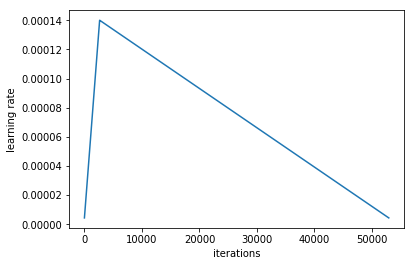

In [41]:
learner.sched.plot_lr()

In [19]:
#learner.save('DeepLabv3+_2')

In [106]:
learner.load('DeepLabv3+_2')

In [107]:
lr=7e-4
wd=1e-7
learner.fit(lr/50, 1, cycle_len=50, wds=wd, use_clr=(100, 50))

epoch      trn_loss   val_loss   accuracy   get_iou                                                                    
    0      0.304035   0.452962   0.630093   0.60599   
    1      0.309871   0.425336   0.638641   0.602259                                                                   
    2      0.310187   0.437225   0.639583   0.593771                                                                   
    3      0.279029   0.460249   0.625162   0.60873                                                                    
    4      0.285479   0.437915   0.644813   0.594663                                                                   
    5      0.31472    0.428333   0.645504   0.590022                                                                   
    6      0.302587   0.439041   0.637206   0.607224                                                                   
    7      0.319246   0.43326    0.637666   0.607213                                                     

KeyboardInterrupt: 

In [93]:
learner.save('DeepLabv3+_3')

In [97]:
#learner.load('DeepLabv3+_3')

### Validation Testing

In [78]:
val_dl = iter(md.val_dl)

In [76]:
learner.load('DeepLabv3+_17')
learner.model.eval()

DeepLabv3_plus(
  (xception_features): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (rep): Sequential(
        (0): SeperableConv2D_same(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


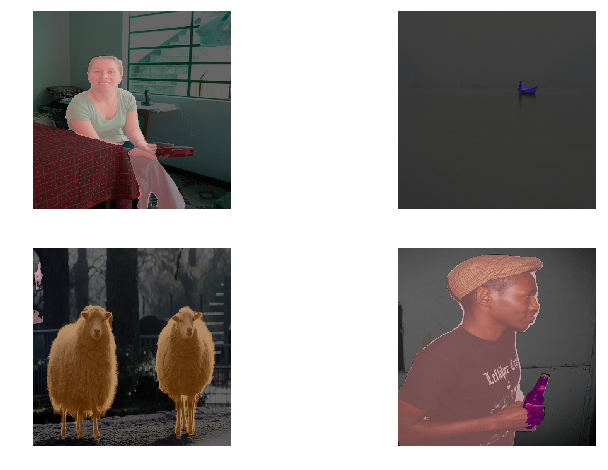

In [86]:
imgs, gts = next(val_dl)
imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
with torch.no_grad():
    outputs = learner.model(imgs)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img, gt = denorm(imgs[i], gts[i])
    out = torch.max(F.log_softmax(outputs[i], dim=0), dim=0)
    out = to_np(out[1])
    ax=show_img(img, ax=ax)
    show_img(decode_segmap(out), ax=ax, alpha=0.6)

### Mean IOUs

In [37]:
#learner.load('DeepLabv3+_10')

In [38]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))


Mean IOU =  0.6525644563226202


In [39]:
learner.load('DeepLabv3+_11')

In [40]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))


Mean IOU =  0.6476396925629488


In [ ]:
#learner.load('DeepLabv3+_13')

In [27]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))


Mean IOU =  0.7201874596093375


In [69]:
learner.load('DeepLabv3+_14')

In [70]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))


Mean IOU =  0.7344659829866869


In [40]:
learner.load('DeepLabv3+_15')

In [41]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))

Mean IOU =  0.759279911273319


In [27]:
learner.load('DeepLabv3+_16')

In [28]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))


Mean IOU =  0.746334010028726


In [46]:
learner.load('DeepLabv3+_17')

In [47]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))

Mean IOU =  0.7646648788433733


In [27]:
learner.load('DeepLabv3+_19')

In [28]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))

Mean IOU =  0.7579580340110751


In [29]:
learner.load('DeepLabv3+_Best')

In [30]:
test_dl = iter(md.val_dl)
iou_list = []
val_len = len(md.val_dl.dataset)
learner.model.eval()

pbar = tqdm_notebook(total=(val_len//bs))
for i, (imgs, gts) in enumerate(md.val_dl):
    imgs, gts = Variable(imgs, requires_grad=True).cuda(), Variable(gts).cuda()
    with torch.no_grad():
        outputs = learner.model(imgs)
    iou = get_iou(outputs, gts)
    iou_list.append(iou)
    pbar.update(1)
pbar.close()
print('Mean IOU = ', np.sum(iou_list)/len(iou_list))

Mean IOU =  0.7632368776632873


## Testing with Sample Images

In [108]:
test_dl = iter(md.test_dl)
learner.load('DeepLabv3+_Best')
learner.model.eval()

DeepLabv3_plus(
  (xception_features): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (rep): Sequential(
        (0): SeperableConv2D_same(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

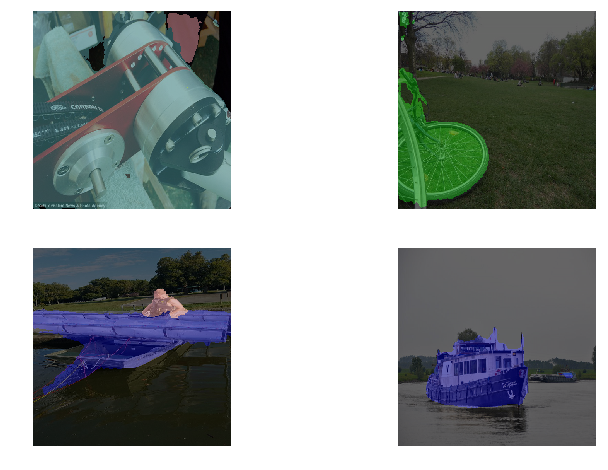

In [114]:
imgs = next(test_dl)
imgs = Variable(imgs, requires_grad=True).cuda()
with torch.no_grad():
    outputs = learner.model(imgs)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img, _ = denorm(imgs[i])
    out = torch.max(F.log_softmax(outputs[i], dim=0), dim=0)
    out = to_np(out[1])
    ax=show_img(img, ax=ax)
    show_img(decode_segmap(out), ax=ax, alpha=0.6)

In [101]:
test_dl = iter(md.test_dl)
learner.load('DeepLabv3+_17')
learner.model.eval()

DeepLabv3_plus(
  (xception_features): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (rep): Sequential(
        (0): SeperableConv2D_same(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

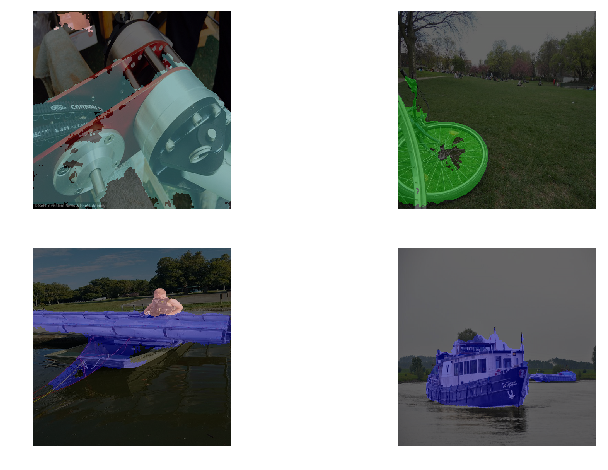

In [107]:
imgs = next(test_dl)
imgs = Variable(imgs, requires_grad=True).cuda()
with torch.no_grad():
    outputs = learner.model(imgs)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img, _ = denorm(imgs[i])
    out = torch.max(F.log_softmax(outputs[i], dim=0), dim=0)
    out = to_np(out[1])
    ax=show_img(img, ax=ax)
    show_img(decode_segmap(out), ax=ax, alpha=0.6)